In [4]:
import sys, os, time
import torch
sys.path.append("../src/")
from run_pdebench_finetuning import get_args, get_model, build_pdebench_dataset
import utils
from einops import rearrange
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [22]:
args = get_args(interactive=True)
args.data_set = 'compNS_turb'
args.mask_type = 'last_frame' # Options are 'tube', 'last_frame'
args.mask_ratio = 0.9
args.model = 'pretrain_videomae_small_patch16_224'
args.decoder_depth = 4
args.batch_size = 24
args.num_workers = 1
args.num_frames = 16
args.norm_target_mode = 'last_frame' # Options are 'videomae', 'last_frame', 'none'
args.gpu = 0
args.device = 'cuda:0'
#args.checkpoint = 'k400_vit-s'
args.checkpoint = 'pdebench_finetuning/k400_small/test/checkpoint-99'

In [23]:
device = torch.device(args.device)

model = get_model(args)
print("Model loaded")
patch_size = model.encoder.patch_embed.patch_size
print("Patch size = %s" % str(patch_size))
args.window_size = (args.num_frames // 2, args.input_size // patch_size[0], args.input_size // patch_size[1])
args.patch_size = patch_size

dataset = build_pdebench_dataset(args, set_type='test')
dataset.random_start = False

Creating model: pretrain_videomae_small_patch16_224
Model loaded
Patch size = (16, 16)
Raw dataset compNS_turb has 1000 samples of shape (512, 512) and 21 timesteps.


In [24]:
# sampler = torch.utils.data.RandomSampler(dataset)
sampler = torch.utils.data.SequentialSampler(dataset)
print("Sampler_train = %s" % str(sampler))
data_loader = torch.utils.data.DataLoader(
        dataset, sampler=sampler,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
        worker_init_fn=utils.seed_worker)

Sampler_train = <torch.utils.data.sampler.SequentialSampler object at 0x7f9ba53ce170>


In [25]:
model.to(device)
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

# print("Model = %s" % str(model))
print('number of params: {} M'.format(n_parameters / 1e6))

number of params: 24.029376 M


In [26]:
args.patch_size

(16, 16)

In [27]:
def plot_reconstruction(samples, recon, mask, batch_index=None, frame_index=None):
    h, w = args.input_size // args.patch_size[0], args.input_size // args.patch_size[1]
    p0, p1, p2 = 2, args.patch_size[0], args.patch_size[1]

    truth = samples

    truth_masked = samples
    truth_masked = rearrange(samples, 'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2 c)', p0=p0, p1=p1, p2=p2)
    truth_masked[mask] = torch.nan
    truth_masked = rearrange(truth_masked, 'b (t h w) (p0 p1 p2 c) -> b c (t p0) (h p1) (w p2)', p0=p0, p1=p1, p2=p2, h=h, w=w)

    recon_full = rearrange(samples, 'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2 c)', p0=p0, p1=p1, p2=p2)
    recon_full[mask] = recon.flatten(start_dim=0, end_dim=1)
    recon_full = rearrange(recon_full, 'b (t h w) (p0 p1 p2 c) -> b c (t p0) (h p1) (w p2)', p0=p0, p1=p1, p2=p2, h=h, w=w)

    if batch_index is None:
        batch_index = np.random.randint(0, args.batch_size)
    if frame_index is None:
        frame_index = np.random.randint(0, args.num_frames)

    truth = truth.cpu().numpy()[batch_index, :, frame_index]
    recon_full = recon_full.cpu().numpy()[batch_index, :, frame_index]
    truth_masked = truth_masked.cpu().numpy()[batch_index, :, frame_index]

    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(3):
        ax[0, i].imshow(truth_masked[i])
        ax[0, i].set_title(f'Input {i}')
        ax[1, i].imshow(recon_full[i])
        ax[1, i].set_title(f'Reconstruction {i}')
        ax[2, i].imshow(truth[i])
        ax[2, i].set_title(f'Truth {i}')
    plt.show()

In [28]:
# bool_masked_pos_fixed = bool_masked_pos.clone()

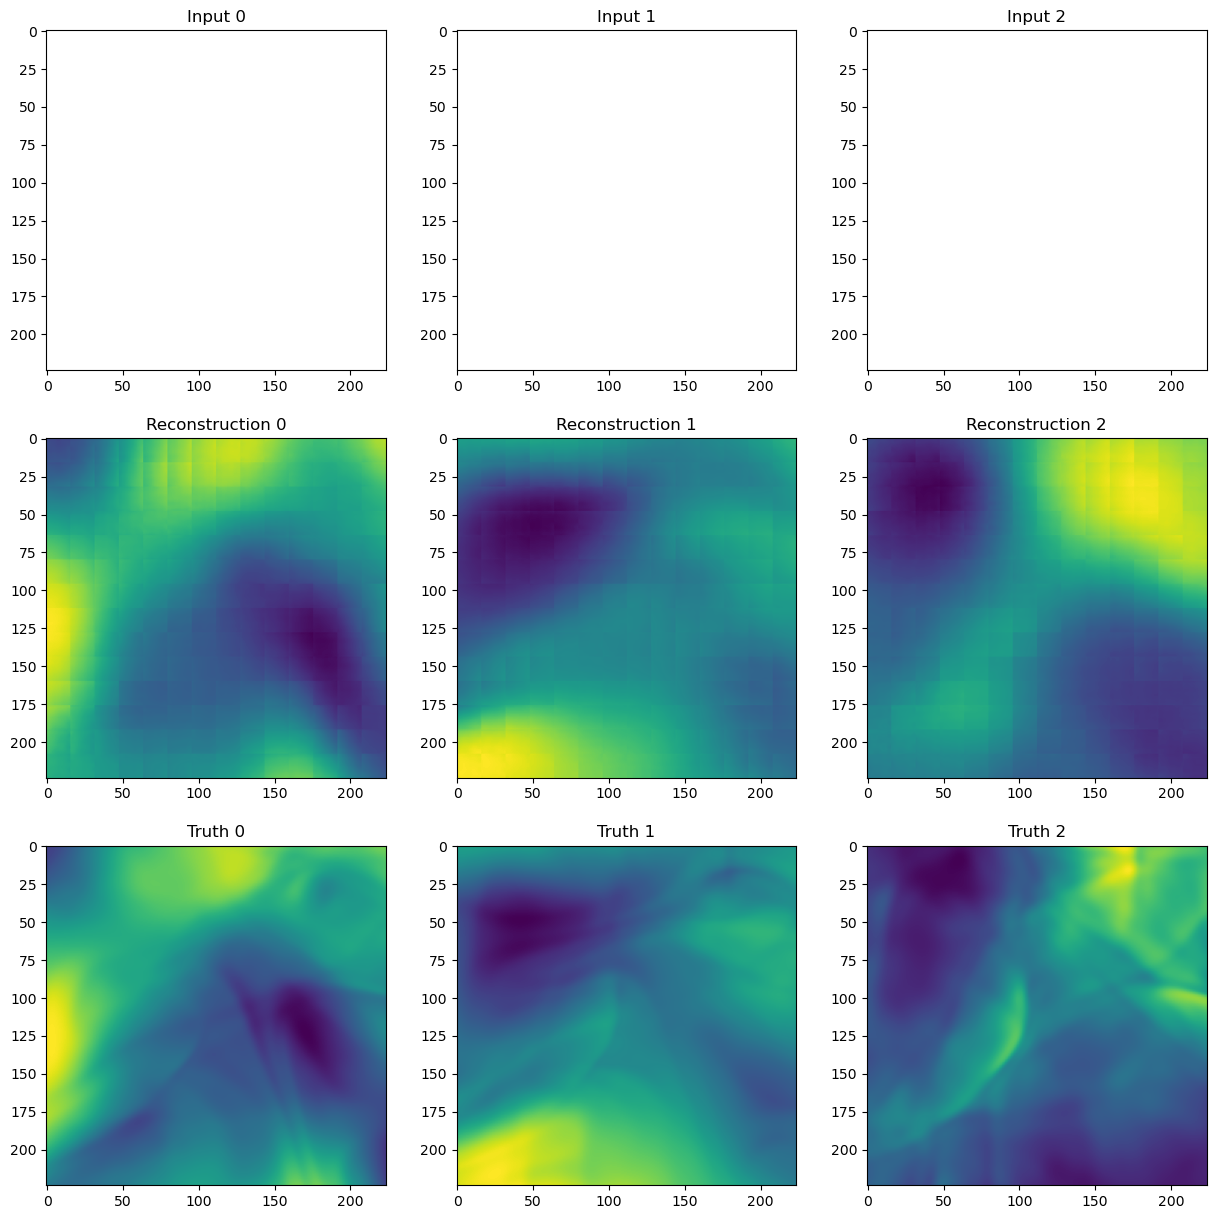

0.1633809208869934


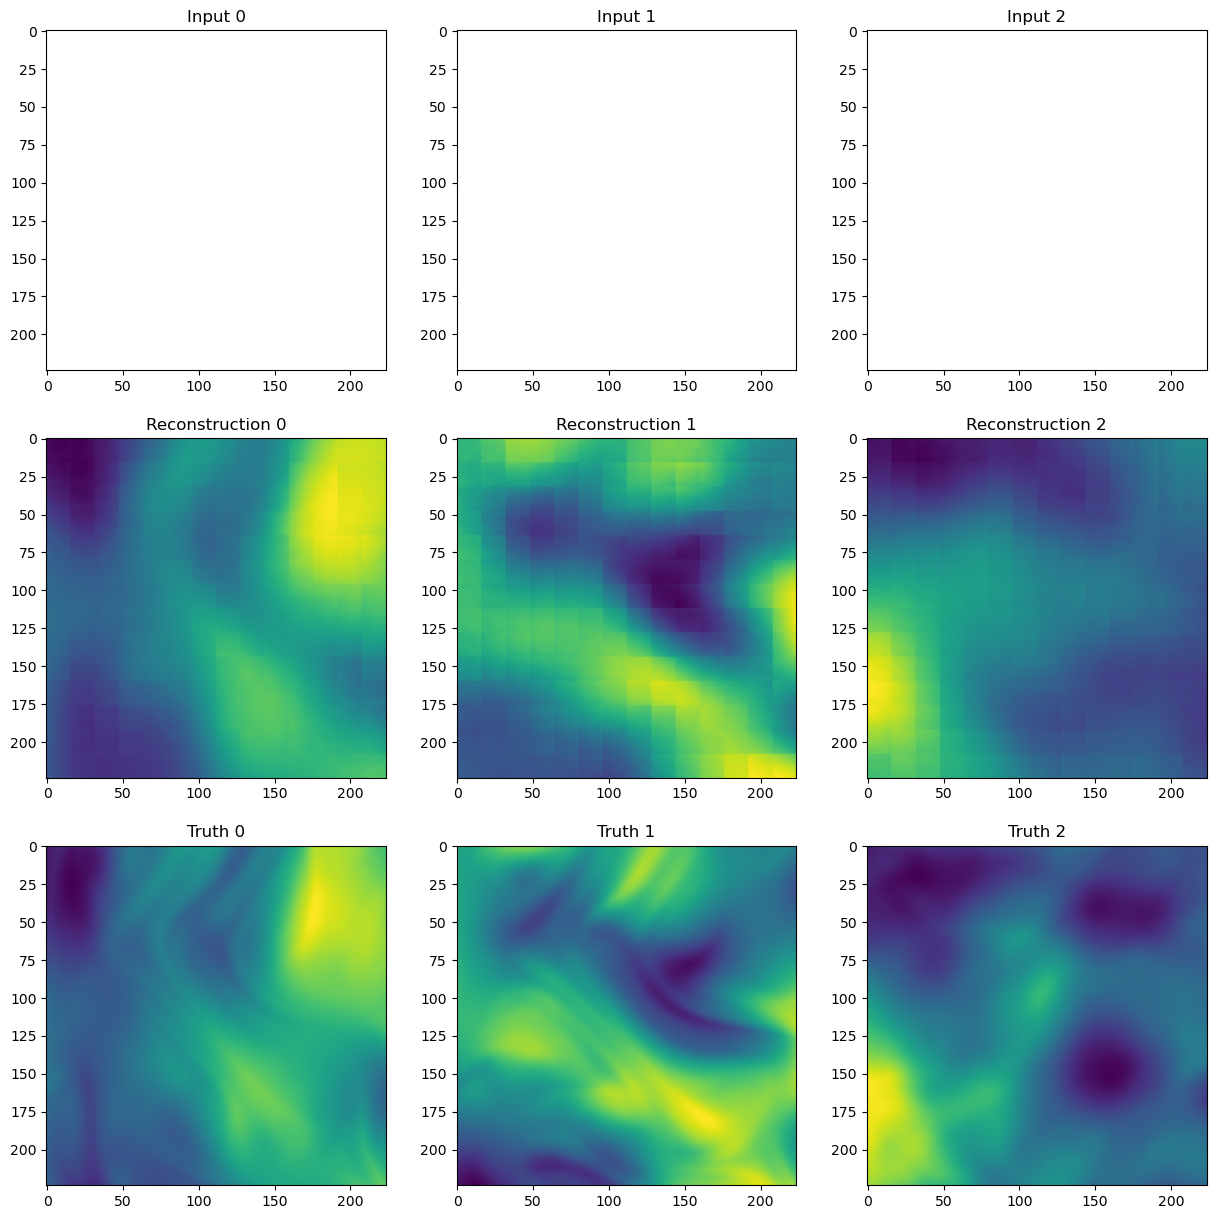

0.15510882437229156


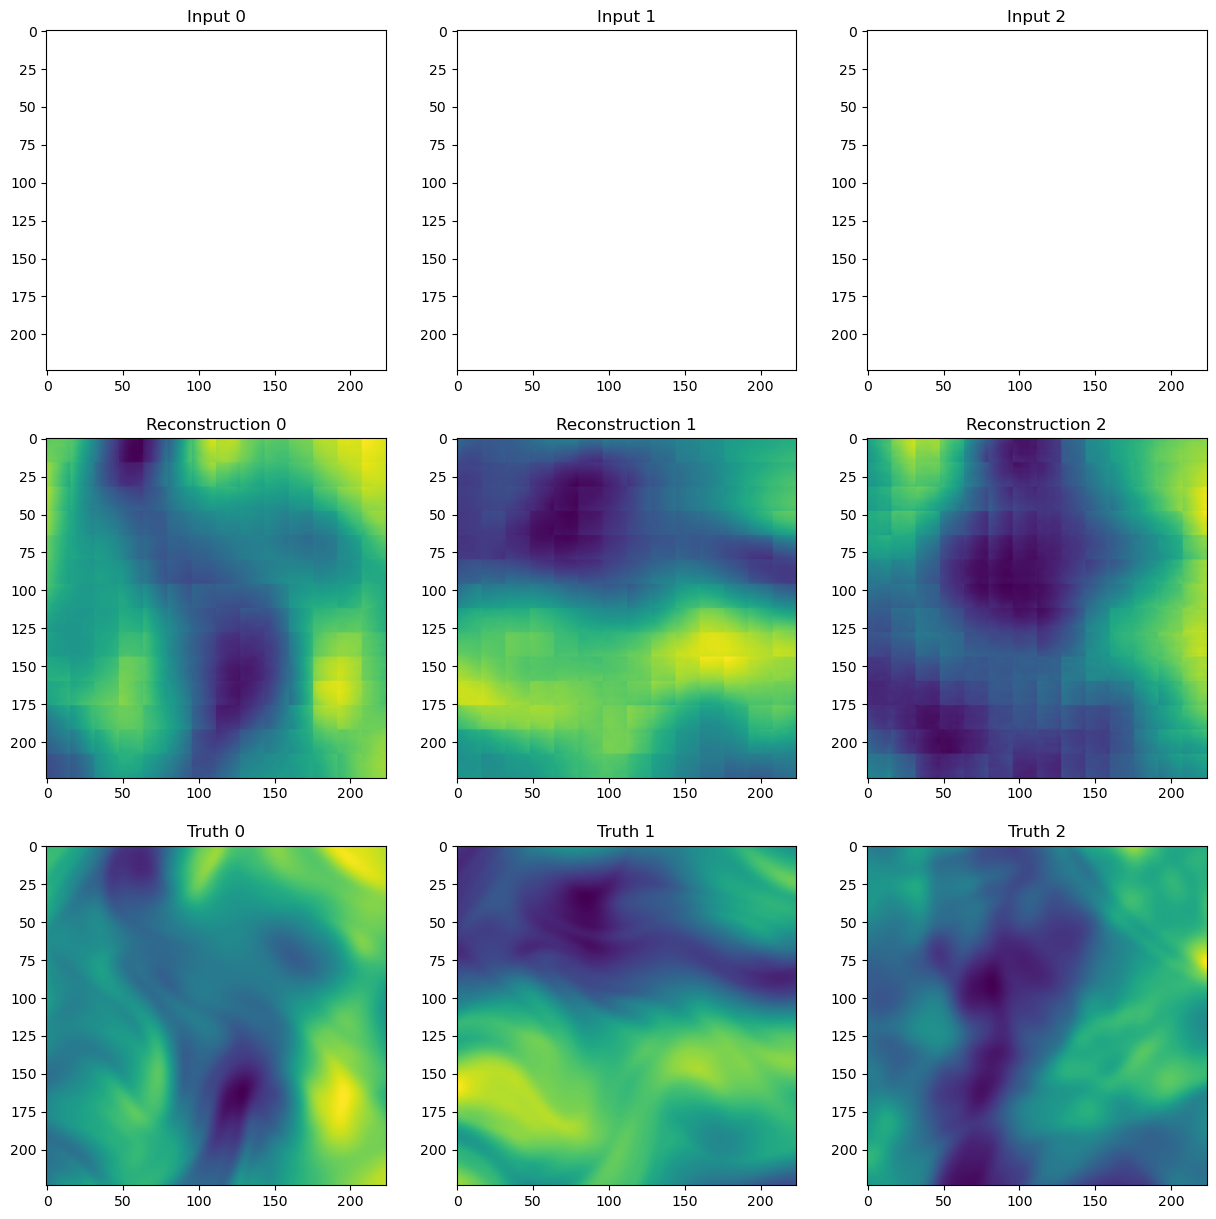

0.16487599909305573


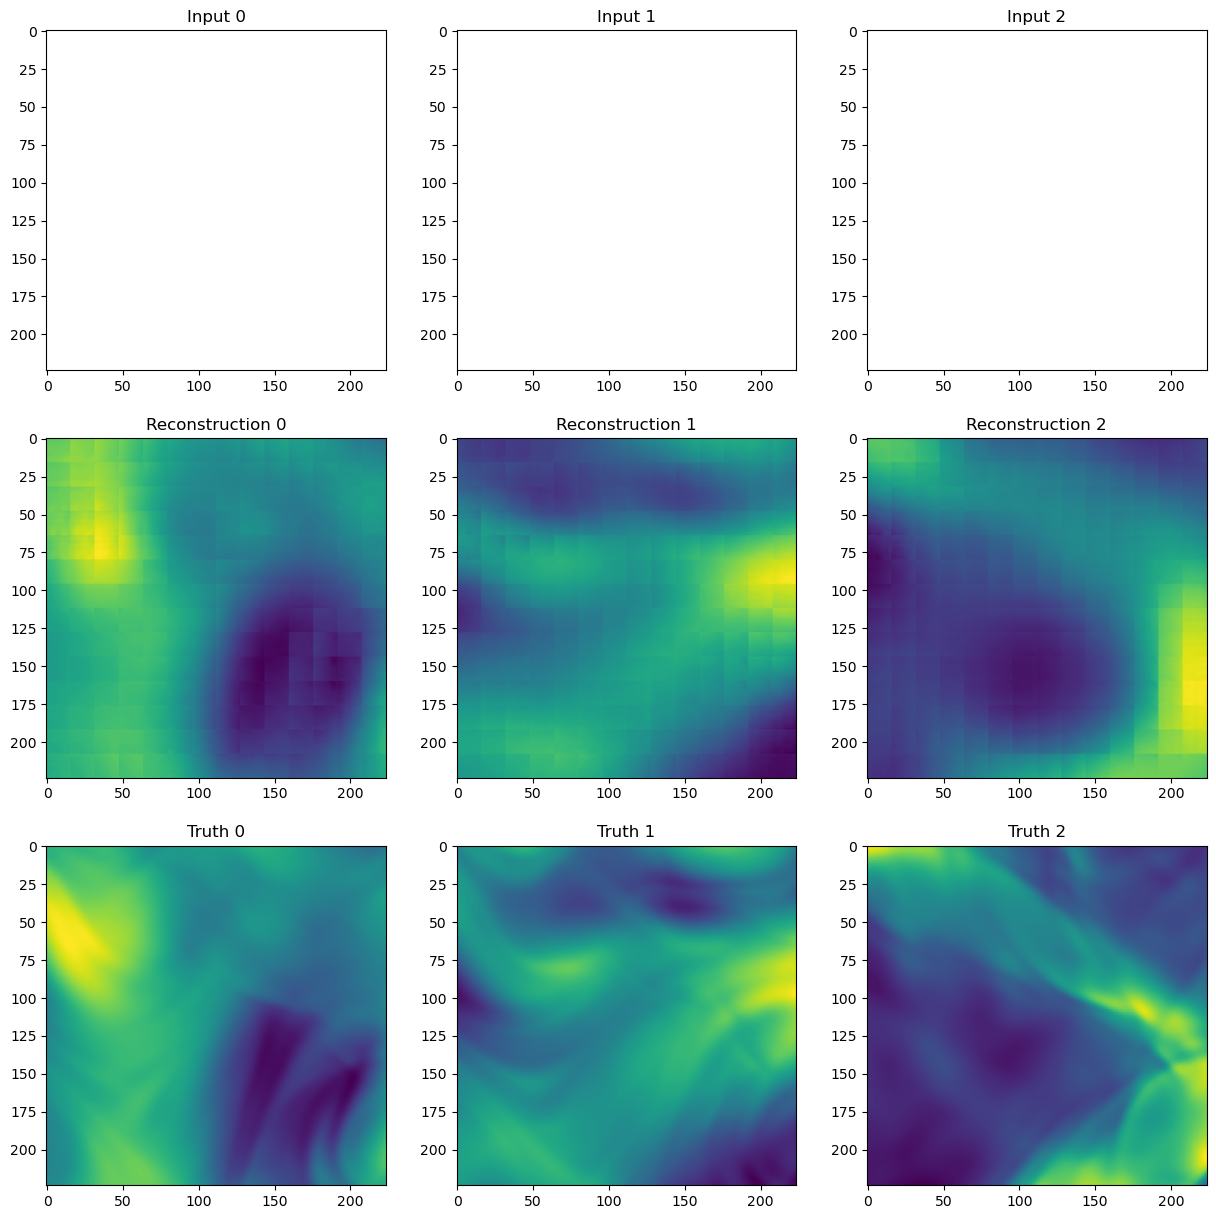

0.18005415797233582


In [29]:
loss_func = nn.MSELoss()

model.eval()
for samples, masks in data_loader:
    samples = samples.to(device, non_blocking=True)
    bool_masked_pos = masks.to(device, non_blocking=True).flatten(1).to(torch.bool)
    # bool_masked_pos = bool_masked_pos_fixed
    p0, p1, p2 = 2, args.patch_size[0], args.patch_size[1]
    nchan = samples.shape[1]
    with torch.no_grad():
        if args.norm_target_mode == 'videomae':
            samples_squeeze = rearrange(samples, 'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2) c', p0=p0, p1=p1, p2=p2)
            samples_squeeze_mean = samples_squeeze.mean(dim=-2, keepdim=True)
            samples_squeeze_std = samples_squeeze.var(dim=-2, unbiased=True, keepdim=True).sqrt() + 1e-6
            samples_norm = (samples_squeeze - samples_squeeze_mean) / samples_squeeze_std
            # we find that the mean is about 0.48 and standard deviation is about 0.08.
            samples_patch = rearrange(samples_norm, 'b n p c -> b n (p c)')
        elif args.norm_target_mode == 'last_frame':
            videos_squeeze = rearrange(samples, 'b c (t p0) (h p1) (w p2) -> b t (h w) (p0 p1 p2) c', p0=p0, p1=p1, p2=p2)
            videos_squeeze_mean = videos_squeeze[:, :-1].mean(dim=(1, 2, 3), keepdim=True)
            videos_squeeze_std = videos_squeeze[:, :-1].var(dim=(1, 2, 3), keepdim=True, unbiased=True).sqrt() + 1e-6
            videos_norm = (videos_squeeze - videos_squeeze_mean) / videos_squeeze_std
            samples_patch = rearrange(videos_norm, 'b t n p c -> b (t n) (p c)')
        elif args.norm_target_mode == 'none':
            samples_patch = rearrange(samples, 'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2 c)', p0=p0, p1=p1, p2=p2)
        else:
            raise NotImplementedError
        B, _, C = samples_patch.shape
        labels = samples_patch[bool_masked_pos].reshape(B, -1, C)

        def unnormalize_outputs(outputs):
            if args.norm_target_mode == 'videomae':
                samples_squeeze_mean_loc = samples_squeeze_mean[bool_masked_pos].reshape(B, -1, 1, nchan)
                samples_squeeze_std_loc = samples_squeeze_std[bool_masked_pos].reshape(B, -1, 1, nchan)
                outputs = rearrange(outputs, 'b n (p c) -> b n p c', c=nchan)
                outputs_unnorm = outputs * samples_squeeze_std_loc + samples_squeeze_mean_loc
                outputs_unnorm = rearrange(outputs_unnorm, 'b n p c -> b n (p c)')
            elif args.norm_target_mode == 'last_frame':
                outputs_unnorm = outputs
            elif args.norm_target_mode == 'none':
                outputs_unnorm = outputs
            else:
                raise NotImplementedError
            return outputs_unnorm
    
        outputs = model(samples, bool_masked_pos)
        plot_reconstruction(samples, unnormalize_outputs(outputs), bool_masked_pos, batch_index=0, frame_index=-1)
        loss = loss_func(input=outputs, target=labels)
        
        loss_value = loss.item()
        print(loss_value)